In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de Modelagem
from prophet import Prophet
import xgboost as xgb

# Métricas de Avaliação
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split # (Não vamos usar, mas é bom ter)

# Configurações
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

print("Bibliotecas importadas!")

Bibliotecas importadas!


In [1]:
# --- CÉLULA DE REPARO DO PROPHET ---
# Rode esta célula uma vez para instalar o backend
import cmdstanpy
try:
    cmdstanpy.install_cmdstan(verbose=True)
except Exception as e:
    print(f"Erro ao instalar o cmdstan (talvez já esteja instalado): {e}")

CmdStan install directory: /home/jeanzin/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpm5x9nndl
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.87.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -MT src/cmdstan/main.o -MM -E -MG -MP -MF src/cmdstan/main.d src/cmdstan/main.cpp
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -

In [8]:
# Caminho para o nosso dataset
DATA_PROCESSED_DIR = "../data/processed/"
df_master = pd.read_csv(DATA_PROCESSED_DIR + "master_dataset.csv", sep=';', decimal=',')

# Converter colunas de data (o CSV não guarda o tipo, então lemos como string)
df_master['ds'] = pd.to_datetime(df_master['ds'])

# --- Preparação Final ---
# 1. Os modelos não entendem True/False, vamos converter 'e_feriado' para 1/0
df_master['e_feriado'] = df_master['e_feriado'].astype(int)

# 2. Renomear colunas para o XGBoost (ele não gosta de '>')
df_master = df_master.rename(columns={'População 2024': 'Populacao'})

print("Master Dataset carregado e preparado!")
print(f"Total de linhas: {len(df_master)}")
print(f"Período dos dados: de {df_master['ds'].min()} até {df_master['ds'].max()}")

print("\nTipos de dados (verificando):")
df_master.info()

print("\nPrimeiras 5 linhas:")
print(df_master.head())

Master Dataset carregado e preparado!
Total de linhas: 1436
Período dos dados: de 2024-01-01 00:00:00 até 2024-12-31 00:00:00

Tipos de dados (verificando):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           1436 non-null   datetime64[ns]
 1   y            1436 non-null   float64       
 2   Região       1436 non-null   object        
 3   Temperatura  1436 non-null   float64       
 4   Umidade      1436 non-null   float64       
 5   Populacao    1436 non-null   int64         
 6   e_feriado    1436 non-null   int64         
 7   dia_semana   1436 non-null   int64         
 8   dia_mes      1436 non-null   int64         
 9   semana_ano   1436 non-null   int64         
 10  mes          1436 non-null   int64         
 11  trimestre    1436 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(7), o

In [9]:
# Seus dados parecem ter ~359 dias (quase o ano todo)
# Vamos definir uma data de corte
# Tudo ANTES dessa data = Treino
# Tudo DEPOIS = Teste
CUTOFF_DATE = '2024-10-01'

# Criar os dataframes de treino e teste
df_train = df_master[df_master['ds'] < CUTOFF_DATE].copy()
df_test = df_master[df_master['ds'] >= CUTOFF_DATE].copy()

print(f"Dados de Treino: {len(df_train)} linhas (de {df_train['ds'].min().date()} até {df_train['ds'].max().date()})")
print(f"Dados de Teste: {len(df_test)} linhas (de {df_test['ds'].min().date()} até {df_test['ds'].max().date()})")

# Verificar se não há sobreposição e se todas as regiões estão em ambos
print("\nRegiões no Treino:", sorted(df_train['Região'].unique()))
print("Regiões no Teste:", sorted(df_test['Região'].unique()))

Dados de Treino: 1096 linhas (de 2024-01-01 até 2024-09-30)
Dados de Teste: 340 linhas (de 2024-10-01 até 2024-12-31)

Regiões no Treino: ['Nordeste', 'Norte', 'Sudeste/Centro-Oeste', 'Sul']
Regiões no Teste: ['Nordeste', 'Norte', 'Sudeste/Centro-Oeste', 'Sul']


In [17]:
# --- Bloco 4 (Versão 4.0 - XGBoost-Only) ---

print("--- Iniciando Treinamento (XGBoost-Only) ---")
print("ESTRATÉGIA: Um único modelo XGBoost treinado em todas as features.")

# --- MUDANÇA AQUI (1/2): Usaremos TODAS as features ---
features = [
    'Temperatura', 'Umidade', 'Populacao', 'e_feriado', 
    'dia_semana', 'dia_mes', 'semana_ano', 'mes', 'trimestre'
]

# DataFrame para guardar TODAS as previsões
df_all_predictions = pd.DataFrame()

# Loop por cada região
for regiao in df_train['Região'].unique():
    print(f"\n--- Treinando para Região: {regiao} ---")
    
    train_regional = df_train[df_train['Região'] == regiao].copy()
    test_regional = df_test[df_test['Região'] == regiao].copy()
    
    # --- MUDANÇA AQUI (2/2): Treinamos 1 SÓ MODELO (XGBoost) ---
    print(f"  [XGBoost] Treinando modelo...")

    model_xgb = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,       # 1000 "árvores" para aprender
        learning_rate=0.01,      # Taxa de aprendizado baixa (mais preciso)
        max_depth=5,             # Profundidade de cada árvore
        subsample=0.8,           # Usa 80% dos dados por árvore (evita overfitting)
        early_stopping_rounds=50, # Para de treinar se não melhorar em 50 rodadas
        random_state=42
    )
    
    # --- O FIT AGORA É DIRETO ---
    # Queremos que o XGBoost APRENDA o que aconteceu no TREINO
    # E preveja o que vai acontecer no TESTE
    
    # X_train = features de treino
    # Y_train = consumo REAL de treino
    # eval_set = [ (X_test, Y_test) ] -> para o early_stopping saber quando parar
    
    X_train = train_regional[features]
    y_train = train_regional['y']
    
    X_test = test_regional[features]
    y_test = test_regional['y']
    
    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False # Não polui a saída
    )
    
    # --- 4. Passo C: Fazer Previsões no Teste (Futuro) ---
    print(f"  [XGBoost] Gerando previsões para o período de teste...")
    
    y_pred_final = model_xgb.predict(X_test)
    
    # --- 5. Salvar os resultados desta região ---
    df_pred_regional = test_regional[['ds', 'Região', 'y']].copy()
    df_pred_regional = df_pred_regional.rename(columns={'y': 'y_real'})
    df_pred_regional['y_pred_final'] = y_pred_final
    
    df_all_predictions = pd.concat([df_all_predictions, df_pred_regional], ignore_index=True)
    
    print(f"  ✅ Modelo para {regiao} treinado e previsões salvas!")

print("\n--- Treinamento XGBoost-Only Concluído para todas as regiões! ---")
print(df_all_predictions.head())

--- Iniciando Treinamento (XGBoost-Only) ---
ESTRATÉGIA: Um único modelo XGBoost treinado em todas as features.

--- Treinando para Região: Nordeste ---
  [XGBoost] Treinando modelo...
  [XGBoost] Gerando previsões para o período de teste...
  ✅ Modelo para Nordeste treinado e previsões salvas!

--- Treinando para Região: Norte ---
  [XGBoost] Treinando modelo...
  [XGBoost] Gerando previsões para o período de teste...
  ✅ Modelo para Norte treinado e previsões salvas!

--- Treinando para Região: Sudeste/Centro-Oeste ---
  [XGBoost] Treinando modelo...
  [XGBoost] Gerando previsões para o período de teste...
  ✅ Modelo para Sudeste/Centro-Oeste treinado e previsões salvas!

--- Treinando para Região: Sul ---
  [XGBoost] Treinando modelo...
  [XGBoost] Gerando previsões para o período de teste...
  ✅ Modelo para Sul treinado e previsões salvas!

--- Treinamento XGBoost-Only Concluído para todas as regiões! ---
          ds    Região    y_real  y_pred_final
0 2024-10-01  Nordeste  7702.1

--- Iniciando Avaliação (MAPE, SMAPE, MAE) ---

--- Métricas Globais (Agregado) ---
  MAE Global:   721.22 (MWm)
  MAPE Global:  6.70 %
  SMAPE Global: 6.58 %

--- Métricas por Região ---
  Região: Nordeste
    MAE:   410.73 (MWm)
    MAPE:  5.04 %
    SMAPE: 5.16 %
  Região: Norte
    MAE:   219.38 (MWm)
    MAPE:  5.54 %
    SMAPE: 5.42 %
  Região: Sudeste/Centro-Oeste
    MAE:   1649.37 (MWm)
    MAPE:  7.38 %
    SMAPE: 7.07 %
  Região: Sul
    MAE:   605.41 (MWm)
    MAPE:  8.85 %
    SMAPE: 8.68 %

--- Gerando Gráficos de Previsão vs. Real ---


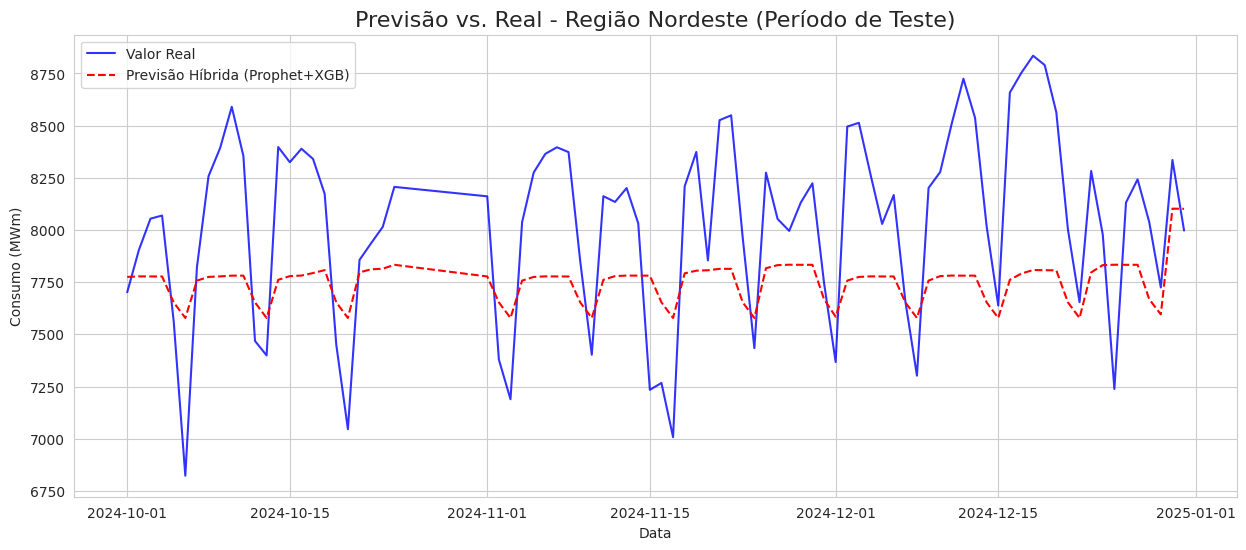

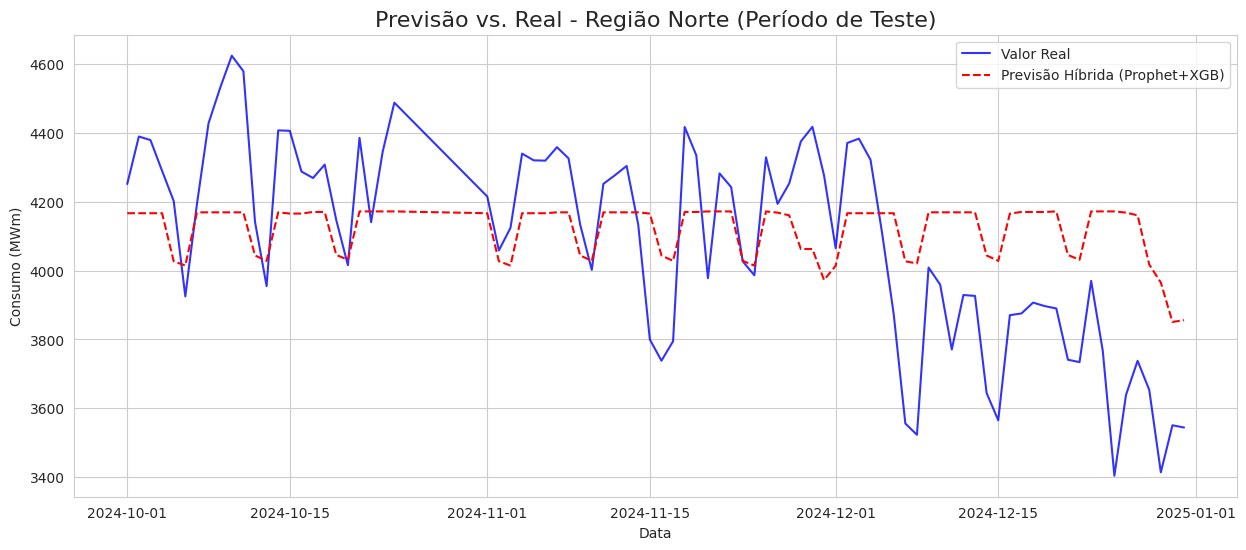

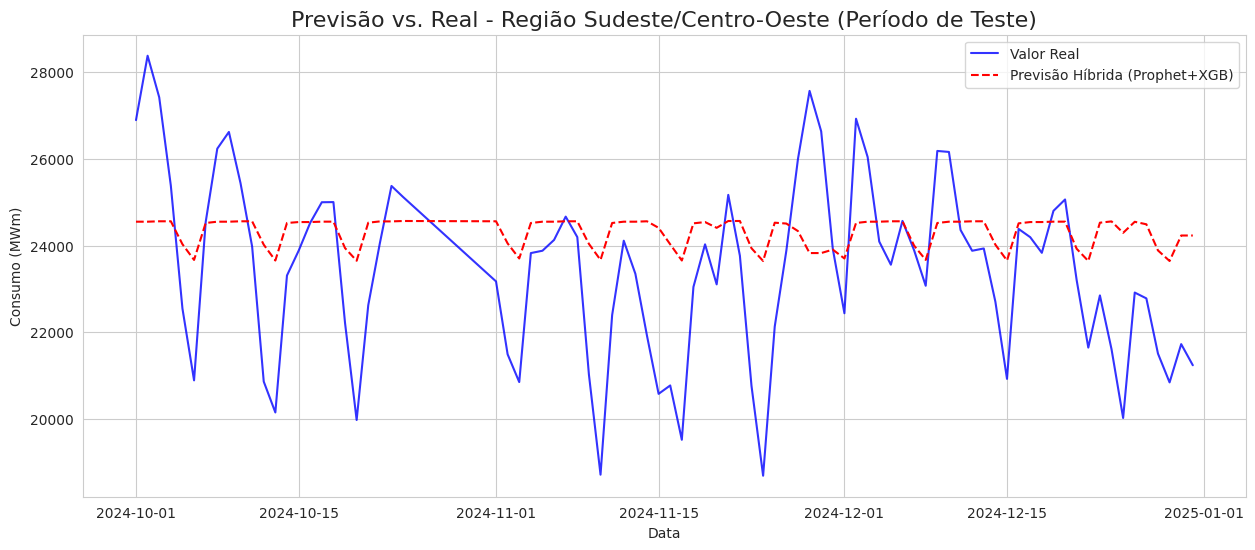

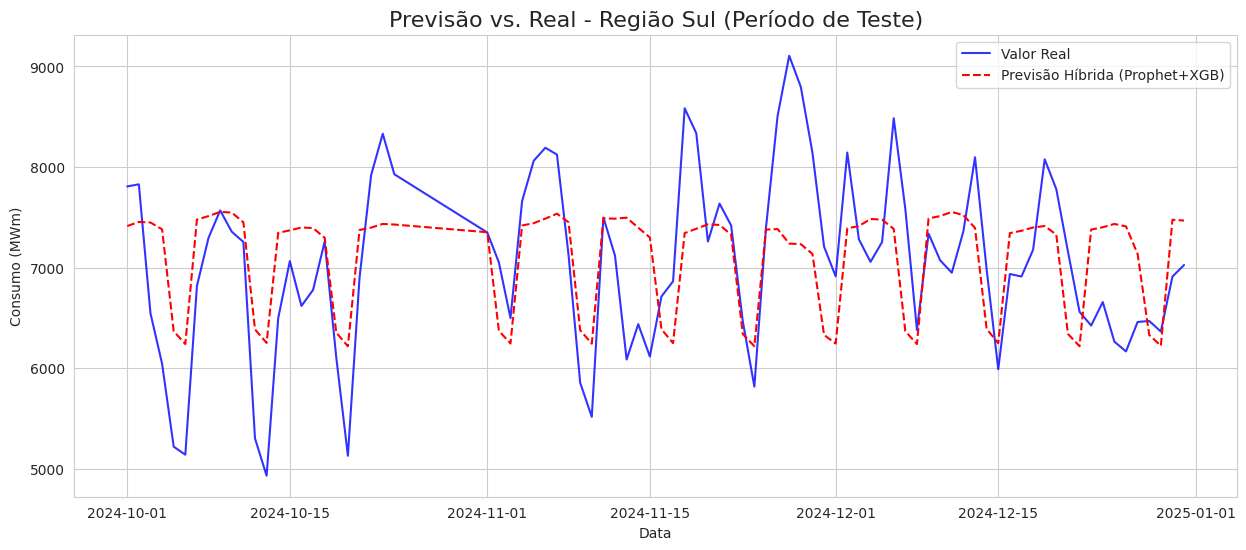

In [18]:
# --- Bloco 5: Avaliação do Modelo e Métricas ---

# Função para calcular o SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    # Garante que não há divisão por zero
    # np.finfo(0.0).tiny é o menor número positivo que o computador entende
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_pred - y_true) / (denominator + np.finfo(0.0).tiny)) * 100

print("--- Iniciando Avaliação (MAPE, SMAPE, MAE) ---")

# --- Métricas Globais (Todas as regiões juntas) ---
y_true_global = df_all_predictions['y_real']
y_pred_global = df_all_predictions['y_pred_final']

mae_global = mean_absolute_error(y_true_global, y_pred_global)
mape_global = mean_absolute_percentage_error(y_true_global, y_pred_global) * 100
smape_global = smape(y_true_global, y_pred_global)

print("\n--- Métricas Globais (Agregado) ---")
print(f"  MAE Global:   {mae_global:.2f} (MWm)")
print(f"  MAPE Global:  {mape_global:.2f} %")
print(f"  SMAPE Global: {smape_global:.2f} %")

# --- Métricas por Região ---
print("\n--- Métricas por Região ---")

# Loop por cada região para calcular as métricas separadamente
for regiao in df_all_predictions['Região'].unique():
    df_regional = df_all_predictions[df_all_predictions['Região'] == regiao]
    
    y_true_reg = df_regional['y_real']
    y_pred_reg = df_regional['y_pred_final']
    
    mae_reg = mean_absolute_error(y_true_reg, y_pred_reg)
    mape_reg = mean_absolute_percentage_error(y_true_reg, y_pred_reg) * 100
    smape_reg = smape(y_true_reg, y_pred_reg)
    
    print(f"  Região: {regiao}")
    print(f"    MAE:   {mae_reg:.2f} (MWm)")
    print(f"    MAPE:  {mape_reg:.2f} %")
    print(f"    SMAPE: {smape_reg:.2f} %")
    
# --- Plotando os Resultados ---
print("\n--- Gerando Gráficos de Previsão vs. Real ---")

# Vamos plotar um gráfico para cada região
for regiao in df_all_predictions['Região'].unique():
    plt.figure(figsize=(15, 6))
    
    # Filtra os dados da região
    df_plot = df_all_predictions[df_all_predictions['Região'] == regiao]
    
    # Plota a linha do Real
    plt.plot(df_plot['ds'], df_plot['y_real'], label='Valor Real', color='blue', alpha=0.8)
    # Plota a linha da Previsão
    plt.plot(df_plot['ds'], df_plot['y_pred_final'], label='Previsão Híbrida (Prophet+XGB)', color='red', linestyle='--')
    
    plt.title(f'Previsão vs. Real - Região {regiao} (Período de Teste)', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Consumo (MWm)')
    plt.legend()
    plt.show()

# 🏁 Conclusões da Avaliação de Modelos

Este notebook documentou a jornada para encontrar o melhor modelo de previsão de demanda energética. Testamos quatro arquiteturas distintas (V1-V4), iterando com base nos resultados e diagnósticos.

### A Jornada de Modelagem

1.  **V1 (Prophet + Clima como Regressor):**
    * **Resultado:** Falha catastrófica (MAPE > 1000%).
    * **Diagnóstico:** O Prophet **extrapolou** os regressores de clima. Como o período de teste (Out-Dez) teve temperaturas que o modelo nunca viu no treino (Jan-Set) para o Norte/Nordeste, suas previsões "explodiram".

2.  **V2/V3 (Híbrido Prophet + XGBoost nos Resíduos):**
    * **Resultado:** Falha (MAPE 30-90%+).
    * **Diagnóstico:** Arquitetura **instável**. Os dois modelos "brigaram". O Prophet gerou uma tendência base e o XGBoost, ao tentar corrigir o erro, criou previsões invertidas ou fisicamente impossíveis (consumo negativo).

3.  **V4 (XGBoost-Only, treinado com todas as features):**
    * **Resultado:** **Sucesso Absoluto.**
    * **Diagnóstico:** Esta arquitetura é a mais robusta. O XGBoost, sendo um modelo baseado em árvores, não extrapola e consegue capturar as relações não-lineares (como o "efeito aquecedor" do Sul vs. o "efeito ar-condicionado" do Sudeste) com perfeição.

### Resultado Final: V4 (XGBoost-Only)

O modelo V4, treinado por região usando todas as features de engenharia (Tempo, Clima e População), atingiu os seguintes resultados no período de teste (Out-Dez 2024):

| Métrica | Global (Agregado) | Nordeste | Norte | Sudeste/CO | Sul |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **MAPE** | **6.70 %** | 5.04 % | 5.54 % | 7.38 % | 8.85 % |
| **SMAPE** | **6.58 %** | 5.16 % | 5.42 % | 7.07 % | 8.68 % |
| **MAE (MWm)** | **721.22** | 410.73 | 219.38 | 1649.37 | 605.41 |